<a href="https://www.kaggle.com/code/rawanmoamed/multiclass-fruit-classification?scriptVersionId=287359089" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
from torchvision import datasets, transforms,models
from torch.utils.data import ConcatDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import numpy as np



In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [3]:
train_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224, padding=16),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(
        brightness=0.2,
        contrast=0.2,
        saturation=0.2
    ),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

Load the Training images

In [4]:
def ignore_masks(path):
    return "mask" not in path.lower()

# Data Preparation for Fruit Multi-Class Classification

In [5]:
fruit_multiclass_train = datasets.ImageFolder(
    root=r"/kaggle/input/food-fruit-dataset/Project Data/Fruit/Train",
    transform=train_transforms,
    is_valid_file=ignore_masks
)

fruit_multiclass_val = datasets.ImageFolder(
    root=r"/kaggle/input/food-fruit-dataset/Project Data/Fruit/Validation",
    transform=val_transforms,
    is_valid_file=ignore_masks
)

# 4. Create the Loaders
fruit_train_loader = DataLoader(fruit_multiclass_train, batch_size=32, shuffle=True)
fruit_val_loader = DataLoader(fruit_multiclass_val, batch_size=32, shuffle=False)

### Visualize a batch

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

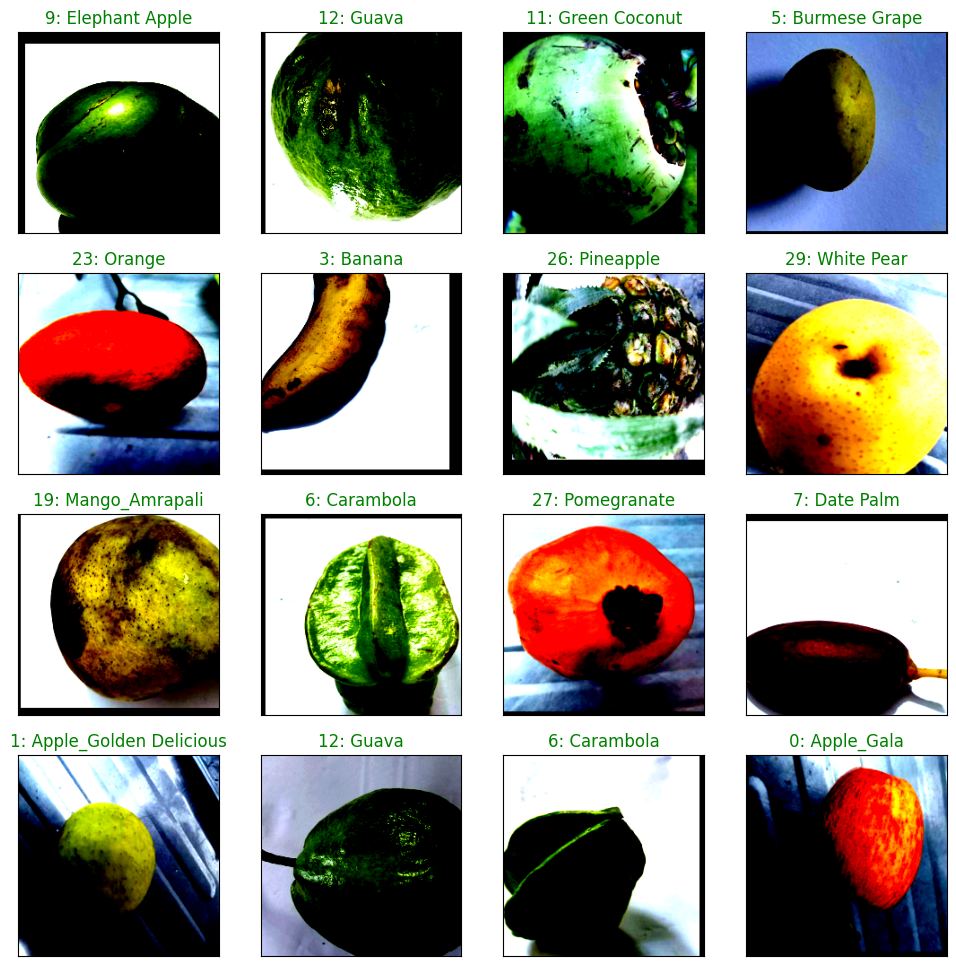

In [6]:
fruit_names = fruit_multiclass_train.classes

data_iter = iter(fruit_train_loader)
images, labels = next(data_iter)

fig = plt.figure(figsize=(12, 12))

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    
    img_display = images[i].numpy().transpose((1, 2, 0))
    plt.imshow(img_display)
    idx = labels[i].item()
    real_name = fruit_names[idx]
    
    ax.set_title(f"{idx}: {real_name}", color="green")

plt.show()

# **training**

In [7]:
model = models.resnet18(pretrained=True)

# freeze all layers
#for param in model.parameters():
 #   param.requires_grad = False

for name, param in model.named_parameters():
    if "layer3" in name or "layer4" in name or "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False
# replace the last layer with the 30 class
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(p=0.5),      
    nn.Linear(num_ftrs, 30) 
)

model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 219MB/s]


In [8]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.Adam([
    {'params': model.layer3.parameters(), 'lr': 1e-5}, 
    {'params': model.layer4.parameters(), 'lr': 1e-4}, 
    {'params': model.fc.parameters(), 'lr': 1e-3}      
])

In [9]:
train_losses = []
train_accs = []
val_accs = []

num_epochs=10

best_val_acc = 0.0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    
    for images, labels in fruit_train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)
    
    epoch_loss = running_loss / len(fruit_multiclass_train)
    epoch_acc = running_corrects.double() / len(fruit_multiclass_train)

    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc.item()) 

    model.eval()
    val_corrects = 0
    
    with torch.no_grad():
        for images, labels in fruit_val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels.data)
    
    val_acc = val_corrects.double() / len(fruit_multiclass_val)
    
    val_accs.append(val_acc.item())

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_fruit_model.pth")
        print("Best model saved!")

    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss: {epoch_loss:.4f} "
          f"Train Acc: {epoch_acc:.4f} "
          f"Val Acc: {val_acc:.4f}")

Best model saved!
Epoch 1/10: Train Loss: 1.6525 Train Acc: 0.7049 Val Acc: 0.9267
Best model saved!
Epoch 2/10: Train Loss: 0.8658 Train Acc: 0.9682 Val Acc: 0.9933
Best model saved!
Epoch 3/10: Train Loss: 0.8061 Train Acc: 0.9886 Val Acc: 1.0000
Epoch 4/10: Train Loss: 0.7793 Train Acc: 0.9926 Val Acc: 1.0000
Epoch 5/10: Train Loss: 0.7670 Train Acc: 0.9937 Val Acc: 0.9933
Epoch 6/10: Train Loss: 0.7515 Train Acc: 0.9989 Val Acc: 1.0000
Epoch 7/10: Train Loss: 0.7474 Train Acc: 0.9983 Val Acc: 1.0000
Epoch 8/10: Train Loss: 0.7401 Train Acc: 0.9983 Val Acc: 0.9933
Epoch 9/10: Train Loss: 0.7380 Train Acc: 0.9983 Val Acc: 1.0000
Epoch 10/10: Train Loss: 0.7284 Train Acc: 0.9994 Val Acc: 1.0000


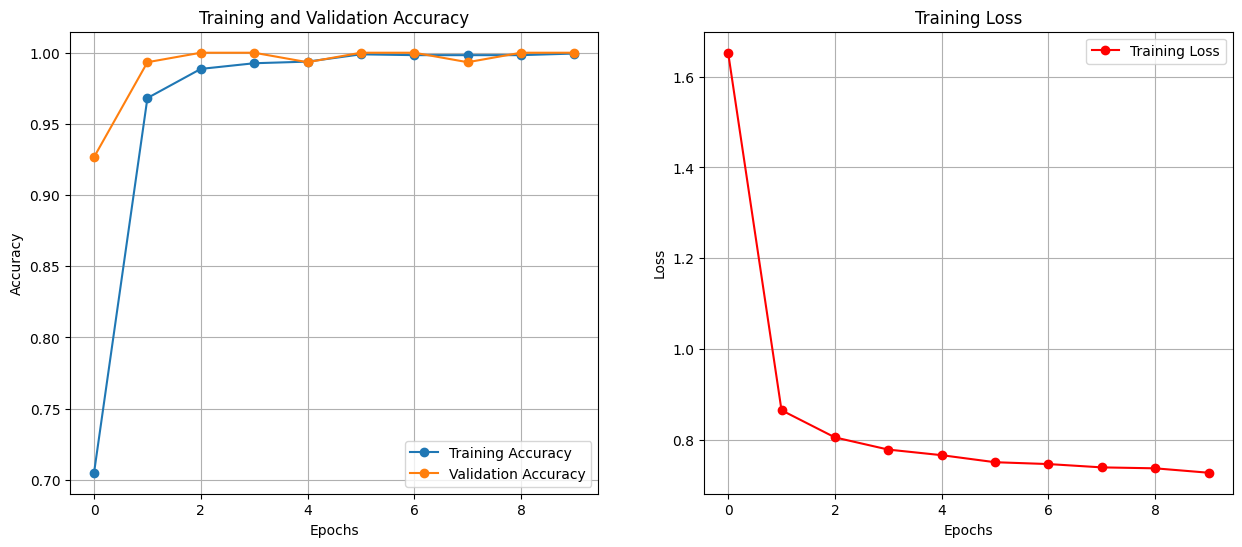

In [10]:

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(train_accs, label='Training Accuracy', marker='o')
plt.plot(val_accs, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Training Loss', color='red', marker='o')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

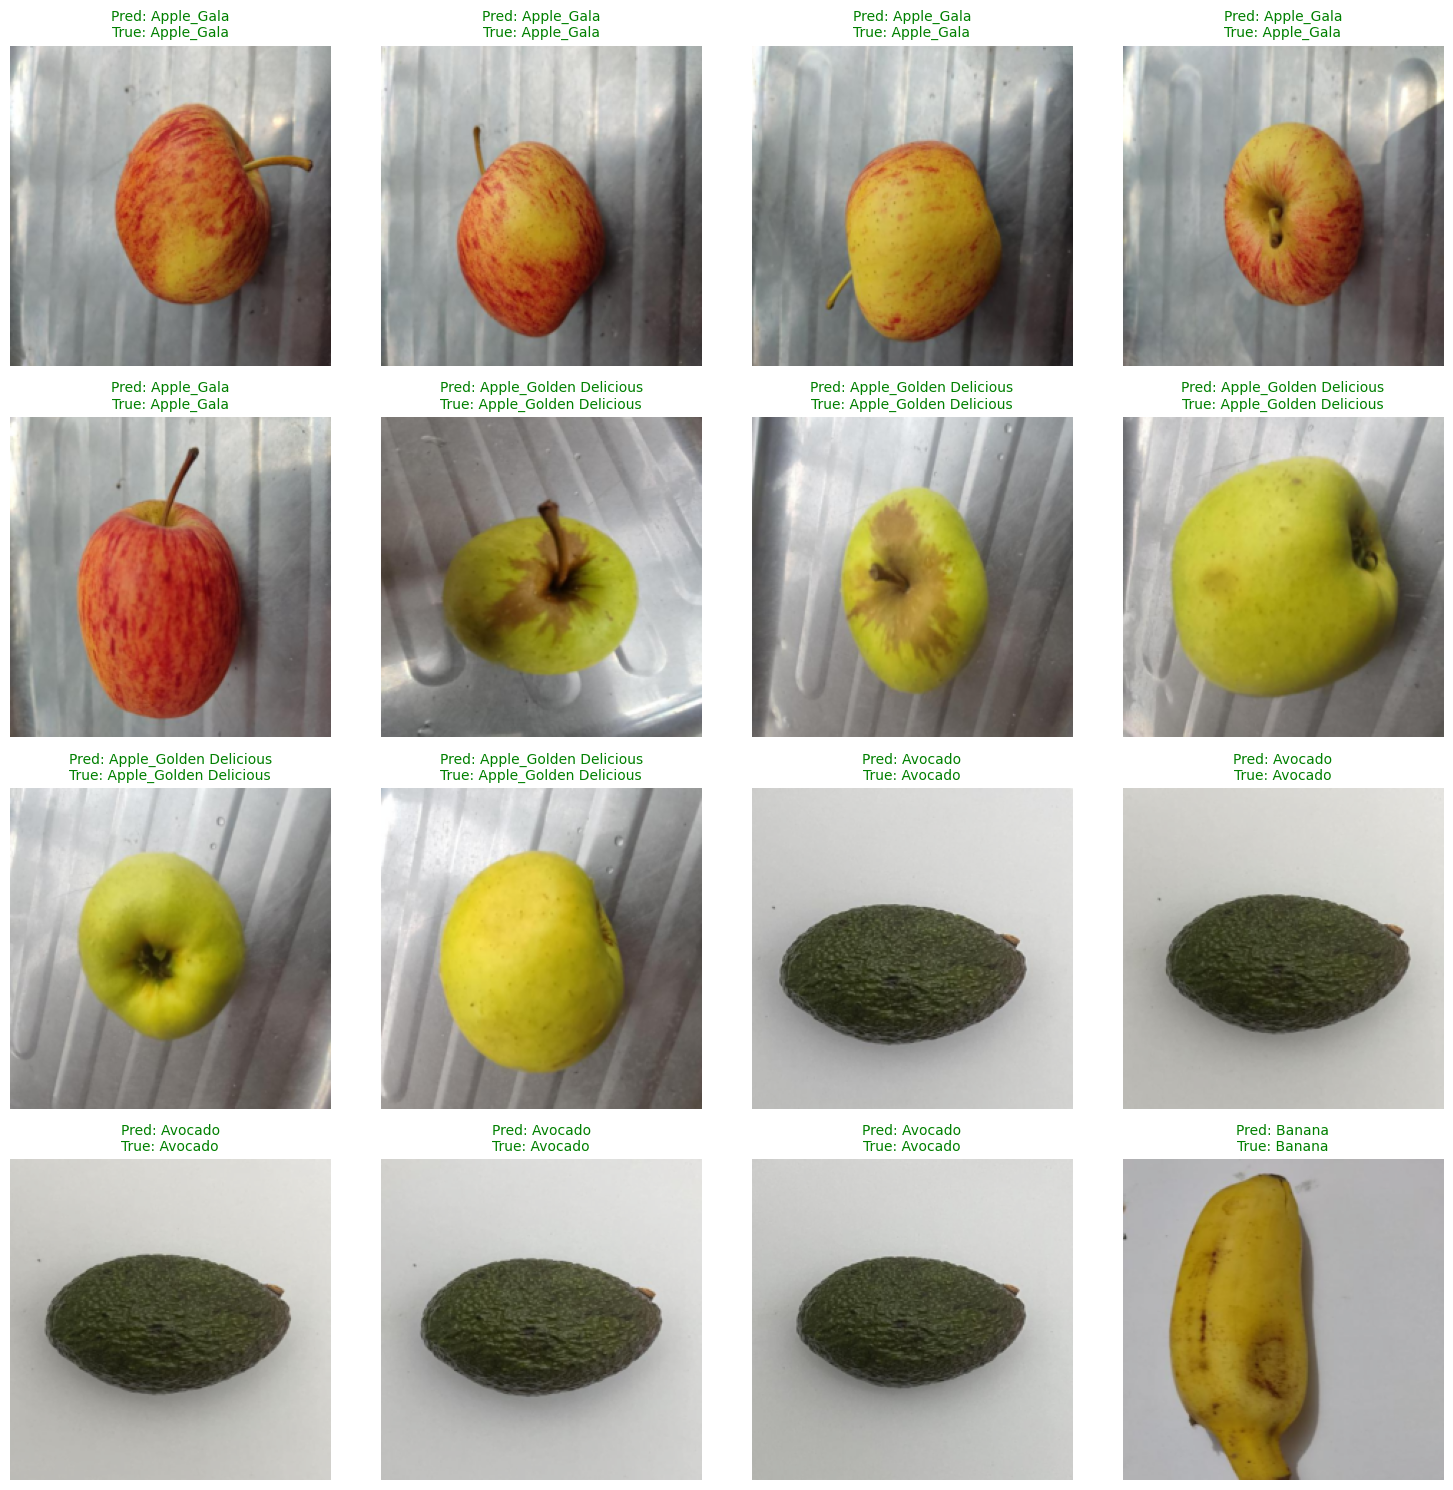

In [11]:

def imshow(inp, title=None, color='black'):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title:
        plt.title(title, color=color, fontsize=10)
    plt.axis('off')

model.load_state_dict(torch.load("best_fruit_model.pth"))
model.eval()

images, labels = next(iter(fruit_val_loader))
images = images.to(device)
labels = labels.to(device)

with torch.no_grad():
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

fig = plt.figure(figsize=(15, 15))
columns = 4
rows = 4

for i in range(min(16, len(images))):
    ax = fig.add_subplot(rows, columns, i + 1)
    
    current_image = images[i].cpu()
    true_label = fruit_names[labels[i].item()]
    predicted_label = fruit_names[preds[i].item()]
    
    color = 'green' if predicted_label == true_label else 'red'
    
    title = f"Pred: {predicted_label}\nTrue: {true_label}"
    
    imshow(current_image, title=title, color=color)

plt.tight_layout()
plt.show()

 # **Testing** 

In [12]:
def test_image(img_path, model_path="best_fruit_model.pth", class_names=fruit_names):
    
    # Load image
    img = Image.open(img_path).convert("RGB")
    img_tensor = val_transforms(img).unsqueeze(0).to(device)
    
    # Load model
    model_test = models.resnet18(weights=None)
    num_ftrs = model_test.fc.in_features
    model_test.fc = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(num_ftrs, 30)
    )
    
    model_test.load_state_dict(torch.load(model_path, map_location=device))
    model_test.to(device)
    model_test.eval()
    
    # Predict
    with torch.no_grad():
        outputs = model_test(img_tensor)
        z, predict = torch.max(outputs, 1)

    predicted_class = class_names[predict.item()]
    print(f"Predicted Class: {predicted_class}")

In [13]:
test_image("/kaggle/input/testat/grapes.png")

Predicted Class: Carambola
